In [1]:
import pickle
from pathlib import Path
from tqdm.auto import tqdm, trange

from sklearn.metrics import roc_auc_score, average_precision_score
from scipy.stats import pearsonr, spearmanr, ttest_ind, ttest_1samp
import numpy as np, pandas as pd

from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
# path2dir = Path('/work/magroup/hanzhan4/model_output/hcformer_pbulk')
path2dir = Path('/home/ubuntu/SeqHiC2RNA/output/model_output/hcformer_pbulk')
with open(path2dir / 'baseline/baseline_test_ahr49sz0.pkl', 'rb') as f:
    baseline_test_output = pickle.load(f).numpy()
with open(path2dir / 'baseline/baseline_valid_ahr49sz0.pkl', 'rb') as f:
    baseline_valid_output = pickle.load(f).numpy()
with open(path2dir / 'baseline/baseline_train_ahr49sz0.pkl', 'rb') as f:
    baseline_train_output = pickle.load(f).numpy()

with open(path2dir / 'hic1d2d/hic1d2d_test_d1xcmvsr.pkl', 'rb') as f:
    hic1d2d_test_output = pickle.load(f).numpy()
with open(path2dir / 'hic1d2d/hic1d2d_valid_d1xcmvsr.pkl', 'rb') as f:
    hic1d2d_valid_output = pickle.load(f).numpy()
with open(path2dir / 'hic1d2d/hic1d2d_train_d1xcmvsr.pkl', 'rb') as f:
    hic1d2d_train_output = pickle.load(f).numpy()

# do not need to modify
with open(path2dir / 'test_expression.pkl', 'rb') as f:
    test_exp = pickle.load(f).numpy()

with open(path2dir / 'valid_expression.pkl', 'rb') as f:
    valid_exp = pickle.load(f).numpy()

with open(path2dir / 'train_expression.pkl', 'rb') as f:
    train_exp = pickle.load(f).numpy()


In [3]:
baseline_test_output.shape, hic1d2d_test_output.shape, test_exp.shape,\
baseline_valid_output.shape, hic1d2d_valid_output.shape, valid_exp.shape,\
baseline_train_output.shape, hic1d2d_train_output.shape, train_exp.shape,

((4488, 240, 1),
 (4488, 240, 1),
 (4488, 240, 1),
 (34408, 240, 1),
 (34408, 240, 1),
 (34408, 240, 1),
 (65824, 240, 1),
 (65824, 240, 1),
 (65824, 240, 1))

In [4]:
def fn_test(x):
    return x.reshape(6, 748, 240).transpose(1, 0, 2).reshape(748, 6 * 240)
def fn_valid(x):
    return x[: 22*748].reshape(22, 748, 240).transpose(1, 0, 2).reshape(748, 22*240), x[22*748:].reshape(6, 2992, 240).transpose(1, 0, 2).reshape(2992, 6*240)
def fn_train(x):
    return x.reshape(22, 2992, 240).transpose(1, 0, 2).reshape(2992, 22*240)
def fn_merge(train, valid, test):
    return np.concatenate((np.concatenate((fn_train(train), fn_valid(valid)[1]), axis=1), np.concatenate((fn_valid(valid)[0], fn_test(test)), axis=1)), axis=0)

train_corr_1d2d = np.array([pearsonr(*_)[0] for _ in tqdm(zip(fn_train(hic1d2d_train_output), fn_train(train_exp)))])
train_corr_baseline = np.array([pearsonr(*_)[0] for _ in tqdm(zip(fn_train(baseline_train_output), fn_train(train_exp)))])


corr_1d2d = np.array([pearsonr(*_)[0] for _ in tqdm(zip(fn_merge(hic1d2d_train_output, hic1d2d_valid_output, hic1d2d_test_output),\
                                                        fn_merge(train_exp, valid_exp, test_exp)))])
corr_baseline = np.array([pearsonr(*_)[0] for _ in tqdm(zip(fn_merge(baseline_train_output, baseline_valid_output, baseline_test_output),\
                                                            fn_merge(train_exp, valid_exp, test_exp)))])

# shape = (6, 748, 240)
# def fn_test(x):
#     return x.reshape(6, 748, 240).transpose(1, 0, 2).reshape(748, 6 * 240)
# corr_1d2d = np.array([pearsonr(*_)[0] for _ in tqdm(zip(fn(hic1d2d_test_output), fn(test_exp)))])
# corr_baseline = np.array([pearsonr(*_)[0] for _ in tqdm(zip(fn(baseline_test_output), fn(test_exp)))])

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [5]:
corr_1d2d.mean(), corr_baseline.mean()

(0.4980828505008007, 0.43629896428478043)

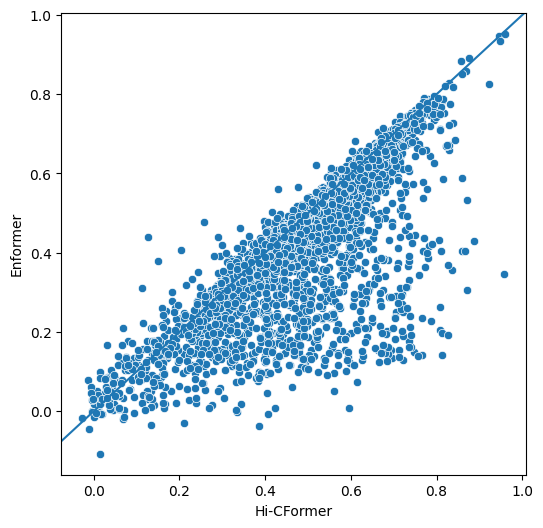

In [6]:
x, y = corr_1d2d, corr_baseline
fig, ax = plt.subplots(figsize=(6, 6))
sns.scatterplot(ax=ax, x=x, y=y)
ax.axline((0, 0), slope=1)
ax.set(xlabel='Hi-CFormer', ylabel='Enformer')
plt.show()
plt.close('all')

In [7]:
# path2dir = Path('/work/magroup/tianming/Researches/seqhic2expr/data/gage-seq-mBC')
path2dir = Path('/home/ubuntu/SeqHiC2RNA/data')
# df_gene = pd.read_csv(path2dir / 'genes.tsv', sep='\t').iloc[2992:]
df_gene = pd.read_csv(path2dir / 'genes.tsv', sep='\t')
df_tfbs = pd.read_csv(path2dir / 'tfbs' / 'hit_r1000_dboth_thr0.csv.gz')
df_tfbs = df_tfbs[df_tfbs.gene_id.isin(df_gene.gene_id)]

In [8]:
df = df_tfbs.set_index(['gene_id', 'tf_name']).hit.unstack().fillna(0).astype(int).loc[df_gene.gene_id]

In [9]:
corr_diff = corr_1d2d - corr_baseline

In [10]:
x = corr_diff
y = df.values
df_test = pd.DataFrame([
    pearsonr(x, _)
    for _ in tqdm(y.T)
], index=df.columns)

  0%|          | 0/251 [00:00<?, ?it/s]

<Axes: xlabel='statistic', ylabel='Count'>

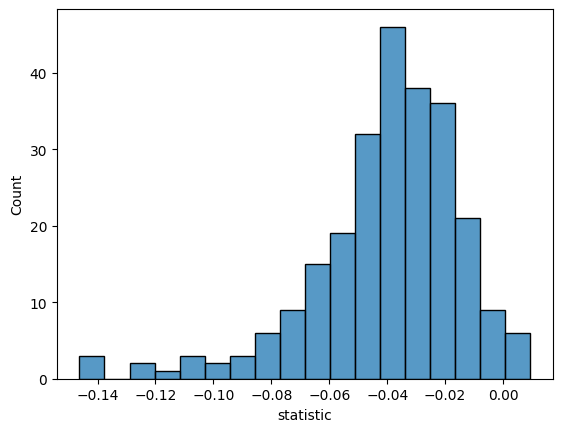

In [11]:
sns.histplot(df_test.statistic)

In [12]:
ttest_1samp(df_test.statistic, 0)

TtestResult(statistic=-24.335425131968517, pvalue=6.967021253120555e-68, df=250)

In [13]:
corr_diff = corr_1d2d + corr_baseline

In [14]:
x = corr_diff
y = df.values
df_test = pd.DataFrame([
    pearsonr(x, _)
    for _ in tqdm(y.T)
], index=df.columns)

  0%|          | 0/251 [00:00<?, ?it/s]

<Axes: xlabel='statistic', ylabel='Count'>

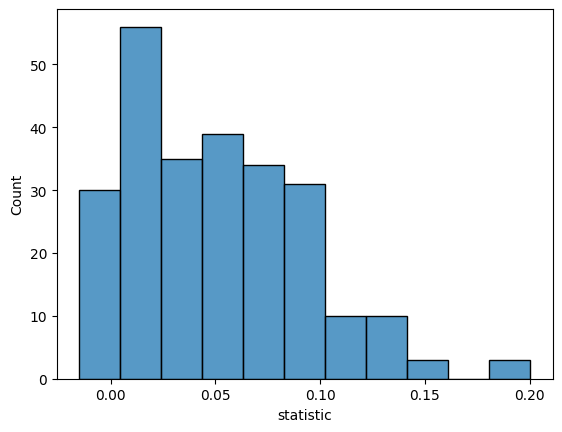

In [15]:
sns.histplot(df_test.statistic)

In [16]:
ttest_1samp(df_test.statistic, 0)

TtestResult(statistic=19.59766373792576, pvalue=1.9309459354270548e-52, df=250)

In [17]:
mask = df_test.pvalue < 1e-3
print(mask.sum())
x = corr_diff
y = df.values[:, mask].mean(1)
pearsonr(x, y)

106


PearsonRResult(statistic=0.25256878743111627, pvalue=1.6118168578521432e-55)

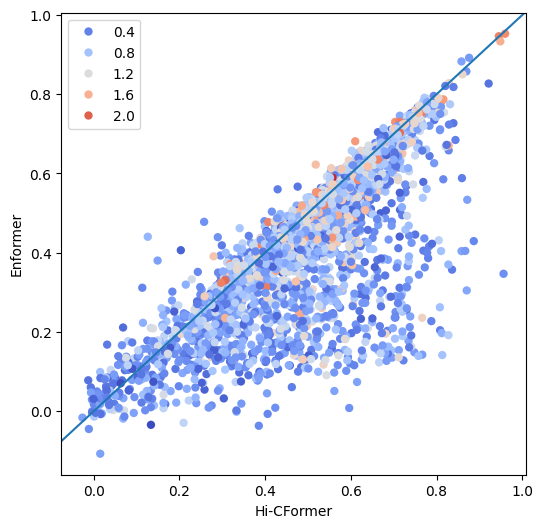

In [18]:
x, y = corr_1d2d, corr_baseline
fig, ax = plt.subplots(figsize=(6, 6))
sns.scatterplot(ax=ax, x=x, y=y, hue=np.log1p(df.values[:, mask].mean(1)), edgecolor='none', palette='coolwarm')
ax.axline((0, 0), slope=1)
ax.set(xlabel='Hi-CFormer', ylabel='Enformer')
plt.show()
plt.close('all')

# Using GO Analysis

In [19]:
import os

# Convert Gene ID to gene name
data_path = '/home/ubuntu/SeqHiC2RNA/data'
gene_name = pd.read_csv(os.path.join(data_path, 'gene_id_conversion.tsv'), sep='\t', names=['gene_id', 'gene_name', 'other'])
df_gene = df_gene.merge(gene_name[['gene_id', 'gene_name']], how='left', on='gene_id')

# Get reference gene name
test_gene_name = df_gene['gene_name']
total_df_gene = pd.read_csv(os.path.join(path2dir, 'genes.tsv'), sep='\t')
total_df_gene = total_df_gene.merge(gene_name[['gene_id', 'gene_name']], how='left', on='gene_id')
total_gene_name = total_df_gene['gene_name']


In [37]:
# Select genes
# !! Need to change here !!

# 1.Both Bad
# select_gene_id = np.where((corr_1d2d < 0.2) & (corr_baseline < 0.2))[0]

# 2.Both Good
# select_gene_id = np.where((corr_1d2d > 0.6) & (corr_baseline > 0.6) & (abs(corr_1d2d-corr_baseline) < 0.1))[0]

# 3. Hicformer is better
select_gene_id = np.where((corr_1d2d - corr_baseline > 0.2) & (corr_baseline > 0.2) & (corr_1d2d > 0.2))[0]

print(len(select_gene_id))

select_gene_name = df_gene['gene_name'].iloc[select_gene_id]

225


In [38]:
# save gene name to csv
go_analysis_path = './go_analysis'
select_gene_name.to_csv(os.path.join(go_analysis_path, 'select_gene_name.txt'), sep='\t', index=False, header=False)
test_gene_name.to_csv(os.path.join(go_analysis_path, 'test_gene_name.txt'), sep='\t', index=False, header=False)
total_gene_name.to_csv(os.path.join(go_analysis_path, 'total_gene_name.txt'), sep='\t', index=False, header=False)


In [39]:
import subprocess

# !! Need to change the output path !!
bash_script = """
path=./go_analysis
for domain in BP CC MF; do
        python pthr_go_annots.py --service enrich --params_file $path/enrich_${domain}.json \
            --seq_id_file $path/select_gene_name.txt --ref_seq_id_file $path/total_gene_name.txt \
            > $path/hicformer_better/go_output_${domain}.txt
done
"""

subprocess.run(bash_script, shell=True, check=True)


CompletedProcess(args='\npath=./go_analysis\nfor domain in BP CC MF; do\n        python pthr_go_annots.py --service enrich --params_file $path/enrich_${domain}.json             --seq_id_file $path/select_gene_name.txt --ref_seq_id_file $path/total_gene_name.txt             > $path/hicformer_better/go_output_${domain}.txt\ndone\n', returncode=0)

In [36]:
# !! Need to change the path here !!
# analysis_path = '/home/ubuntu/SeqHiC2RNA/go_analysis/both_bad'
# analysis_path = '/home/ubuntu/SeqHiC2RNA/go_analysis/both_good'
analysis_path = '/home/ubuntu/SeqHiC2RNA/go_analysis/hicformer_better'

domain = ['BP', 'CC', 'MF']
total_select_go = []
for d in domain:
    go = pd.read_csv(os.path.join(analysis_path, f'go_output_{d}.txt'), sep='\t', skiprows=2)
    select_go = go[go['raw P value'] < 1e-3]
    total_select_go.append(select_go)

total_select_go = pd.concat(total_select_go, ignore_index=True)
total_select_go.to_csv(os.path.join(analysis_path, 'final_result.tsv'), sep='\t', index=False)


# DEG Analysis

In [20]:
# find not 1-1 mapping genes
df = pd.read_csv('./data/gene_id_conversion.tsv', sep='\t', header=None, names=['gene_id', 'name', 'type'])
counts = df.groupby('name')['gene_id'].nunique()
multiple_names_gene_ids = counts[counts > 1]
multiple_names_gene_ids = list(multiple_names_gene_ids.index)

directory = '/home/ubuntu/SeqHiC2RNA/data/DEG-Seurat'

# Select genes from DEG results files
for filename in os.listdir(directory):
    if filename.endswith("-MAST.csv"):
        filepath = os.path.join(directory, filename)
        df = pd.read_csv(filepath)
        df.rename(columns={'Unnamed: 0': 'name'}, inplace=True)
        
        selected_genes = df[(df['p_val_adj'] < 1e-3) & (abs(df['avg_log2FC']) > 0.1) & (~df['name'].isin(multiple_names_gene_ids))]
        
        output_filename = os.path.join(directory, 'selected_files', filename.replace("-MAST.csv", "-selected.csv"))
        selected_genes.to_csv(output_filename, index=False)

        print(f"Processed {filename}, selected {selected_genes.shape[0]} genes.")

Processed Ssta-Vip-MAST.csv, selected 135 genes.
Processed Sncg-Lamp5-MAST.csv, selected 69 genes.
Processed L5ITRSP-L56NPCTX-MAST.csv, selected 213 genes.
Processed Pvalba-Sst-MAST.csv, selected 217 genes.
Processed Pvalba-Ssta-MAST.csv, selected 176 genes.
Processed L45ITCTX-L5ITRSP-MAST.csv, selected 88 genes.
Processed L2ITRvPP-L23ITCTXb-MAST.csv, selected 444 genes.
Processed L23ITCTXb-L23ITCTX-MAST.csv, selected 26 genes.
Processed L23ITRSP-L23ITCTX-MAST.csv, selected 117 genes.
Processed L6CTCTXa-L23ITCTX-MAST.csv, selected 600 genes.
Processed L5ITCTX-L5PTCTX-MAST.csv, selected 89 genes.
Processed Ssta-Pvalb-MAST.csv, selected 168 genes.
Processed L6ITCTX-L6CTCTX-MAST.csv, selected 349 genes.
Processed L6CTCTXa-L56NPCTX-MAST.csv, selected 200 genes.
Processed IT-CT-MAST.csv, selected 861 genes.
Processed L23ITCTXc-L6ITCTX-MAST.csv, selected 197 genes.
Processed Pvalba-Sncg-MAST.csv, selected 180 genes.
Processed L23ITCTX-L6CTCTX-MAST.csv, selected 968 genes.
Processed IT-NP-MAS

In [21]:
# select gene from model prediction
# can change the selection criteria here

# 1. Select from training set
select_gene_id = np.where((train_corr_1d2d - train_corr_baseline > 0.2) & (train_corr_baseline > 0.2) & (train_corr_1d2d > 0.2))[0]

# 2. Select from the whole set
# select_gene_id = np.where((corr_1d2d - corr_baseline > 0.2) & (corr_baseline > 0.2) & (corr_1d2d > 0.2))[0]


select_gene_name = df_gene['gene_name'].iloc[select_gene_id]
select_gene_name = select_gene_name[~select_gene_name.isin(multiple_names_gene_ids)]


In [30]:
from scipy.stats import fisher_exact

directory = '/home/ubuntu/SeqHiC2RNA/data/DEG-Seurat/selected_files'

total_ftest_pval = []

# select total gene name
# 1. select from training set
total_gene_name = df_gene['gene_name'][:2992]

# delete the not 1-1 mapping genes
total_gene_name = total_gene_name[~total_gene_name.isin(multiple_names_gene_ids)]

for filename in os.listdir(directory):
    if filename.endswith("-selected.csv"):
        filepath = os.path.join(directory, filename)
        df = pd.read_csv(filepath)

        conf_matrix = {'TP': 0, 'FP': 0, 'FN': 0, 'TN': 0}
        for gene in total_gene_name:
            if gene in select_gene_name.values and gene in df['name'].values:
                conf_matrix['TP'] += 1
            elif gene in df['name'].values:
                conf_matrix['FP'] += 1
            elif gene in select_gene_name.values:
                conf_matrix['FN'] += 1
            else:
                conf_matrix['TN'] += 1
        matrix = [
            [conf_matrix['TP'], conf_matrix['FP']],
            [conf_matrix['FN'], conf_matrix['TN']]
        ]
        odds_ratio, p_value = fisher_exact(matrix, alternative='greater')
        total_ftest_pval.append(p_value)  

In [38]:
total_ftest_pval = np.array(total_ftest_pval)
loc = np.where(total_ftest_pval > 5e-2)[0]
len(loc)

11